In [21]:
# import libraries
import pandas as pd
import numpy as np
import os

# Model Tuning

Before training a SageMaker estimator our Random Forrest model was first tuned determine the best hyperparamters for future use. Here GridSearchCV was used which exhastivley considers all parameter combinations defined in the param grid.

In [22]:
from sklearn.model_selection import train_test_split

#Load in the training data
TRAIN_SIZE=0.8
data_dir = './data/model/'
df = pd.read_csv(data_dir+'train.csv', header=None)
X_train = df.drop(df.columns[0], axis=1)
y_train = df[df.columns[0]]


check the class distribution so we know our model is doing work

In [23]:
# Null accuracy is the accuracy if we were to only pick the most prevelant class
null_acc=round((y_train.count()-y_train.sum())/y_train.count(), 4)
print("""
    Total Observations: {obsv}
    Total fake Followers: {ff}
    Null Accuracy: {null_acc}
""".format(obsv=y_train.count(), ff=y_train.sum(), 
    null_acc=null_acc))



    Total Observations: 5456
    Total fake Followers: 2666
    Null Accuracy: 0.5114



In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RANDOM_STATE=42
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True], # Whether bootstrap samples are used when building trees
    'max_depth': [5, 10, 20], # The maximum depth of the tree
    'max_features': ['sqrt', 'log2'], # The number of features to consider when looking for the best split
    'min_samples_leaf': [5, 10, 20], # The minimum number of samples required to be at a leaf node
    'min_samples_split': [10, 20, 50], # The minimum number of samples required to split an internal node
    'n_estimators': [5, 10, 100, 200, 300] # Number of trees in the forest
}
model = RandomForestClassifier(random_state=RANDOM_STATE)
grid_cv = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_cv.fit(X_train, y_train)
print("best params: " , grid_cv.best_params_)

best params:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
CPU times: user 5.81 s, sys: 369 ms, total: 6.17 s
Wall time: 6min 49s


In [25]:
print('mean accuracy score: ', grid_cv.best_score_)

mean accuracy score:  0.9895525494975541


Mean accuracy score is above Null Accuracy, so our classifier is doing work

# LOAD Data to S3

In [26]:
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [27]:
# should be the name of directory you created to save your features data
data_dir = './data/model'

# set prefix, a descriptive name for a directory  
prefix = 'capstone_project'

# upload all data to S3
training_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix, extra_args=None)

In [28]:
training_data ='s3://sagemaker-us-east-1-821647692196/capstone_project'

## Confirm data made it to S3

In [29]:
import boto3
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

capstone_project/test.csv
capstone_project/train.csv
sagemaker-scikit-learn-2022-01-08-20-49-08-062/debug-output/training_job_end.ts
sagemaker-scikit-learn-2022-01-08-20-49-08-062/output/model.tar.gz
sagemaker-scikit-learn-2022-01-08-20-49-08-062/profiler-output/framework/training_job_end.ts
sagemaker-scikit-learn-2022-01-08-20-49-08-062/profiler-output/system/incremental/2022010820/1641675060.algo-1.json
sagemaker-scikit-learn-2022-01-08-20-49-08-062/profiler-output/system/incremental/2022010820/1641675120.algo-1.json
sagemaker-scikit-learn-2022-01-08-20-49-08-062/profiler-output/system/training_job_end.ts
sagemaker-scikit-learn-2022-01-08-20-49-08-062/rule-output/ProfilerReport-1641674948/profiler-output/profiler-report.html
sagemaker-scikit-learn-2022-01-08-20-49-08-062/rule-output/ProfilerReport-1641674948/profiler-output/profiler-report.ipynb
sagemaker-scikit-learn-2022-01-08-20-49-08-062/rule-output/ProfilerReport-1641674948/profiler-output/profiler-reports/BatchSize.json
sagemak

# Train The Model
## Training Script

In [30]:
!pygmentize source_sklearn/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
from sklearn.externals import joblib
# Import joblib package directly
#import joblib

# import sklearn library
from sklearn.ensemble import RandomForestClassifier



# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()
    
    
    # hyperparameters sen

## Train the estimator

In [31]:
from sagemaker.sklearn.estimator import SKLearn

estimator = SKLearn(entry_point='train.py',
                    source_dir='source_sklearn',
                    role=role,
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    sagemaker_session=sagemaker_session,
                    py_version='py3',
                    framework_version='0.20.0',
                    hyperparameters=grid_cv.best_params_) # pass the bets params to the training script

In [32]:
## Train the estimator
estimator.fit({'train':training_data})

2022-01-08 21:52:51 Starting - Starting the training job...
2022-01-08 21:53:14 Starting - Launching requested ML instancesProfilerReport-1641678770: InProgress
......
2022-01-08 21:54:14 Starting - Preparing the instances for training............
2022-01-08 21:56:14 Downloading - Downloading input data...
2022-01-08 21:56:43 Training - Downloading the training image...
2022-01-08 21:57:17 Uploading - Uploading generated training model
2022-01-08 21:57:17 Completed - Training job completed
2022-01-08 21:57:06,614 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-01-08 21:57:06,616 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-08 21:57:06,626 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-01-08 21:57:07,018 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-08 21:57:08,450 sagemaker-training-toolkit INFO     No GPUs detected (no

## Deploying trained model

In [33]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------!

In [34]:
predictor

# Model Evaluation

In [35]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

# Determine Accuracy of Model

In [36]:
test_y_preds = predictor.predict(test_x)

## Test Cell
Make sure we have the right number of predictions

In [37]:
# test that your model generates the correct number of labels
assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [38]:
from sklearn.metrics import accuracy_score

# calculate accuracy score
accuracy = accuracy_score(test_y, test_y_preds)

print("Accuracy Score: ", accuracy)



Accuracy Score:  0.9882697947214076


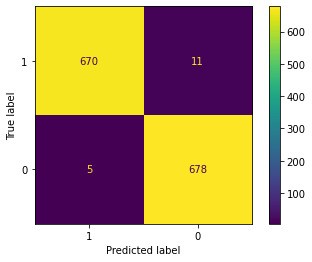

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Plot the confusion matrix
confusion_mat = confusion_matrix(test_y, test_y_preds, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,
                               display_labels=[1,0])
disp.plot()
plt.show()

# Clean up

In [40]:
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))
            
delete_endpoint(predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted sagemaker-scikit-learn-2022-01-08-21-57-34-972
